<a href="https://colab.research.google.com/github/bensenberner/airline-sentiment-prediction/blob/master/Airline_and_Sentiment140.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from fastai.text import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import pandas as pd
data_path = 'drive/My Drive/airline-sentiment'
bs=24

seed=42
import numpy
numpy.random.seed(seed)
import os
os.environ['PYTHONHASHSEED']=str(seed)
import random
random.seed(seed)

# Airline+Sentiment140 Language Model
See EDA notebook in [notebooks/Data.ipynb](https://github.com/bensenberner/airline-sentiment-prediction) to learn how I created the airline+sentiment140 dataset. It's twice as large as the airline dataset but has the same distribution of labels as the airline dataset.

In [ ]:
lm_data = (
    TextList
    .from_csv(data_path, 'sent140_and_airline_balanced_text_only.csv')
    .split_by_rand_pct(0.1, seed=seed)
    .label_for_lm()
    .databunch(bs=bs)
)
lm_data.save('sent140_lm_data')

In [ ]:
lm_data.show_batch()

idx,text
0,"after i sent it to you . xxmaj made it to xxmaj austin , but am now waiting for the luggage . xxbos xxunk xxmaj xxunk ! xxmaj hope you like the intro ' on xxup dd xxmaj ca n't wait to get you out xxunk for us . xxmaj whoop whoop ! xxbos xxmaj sad babies make for xxunk writing xxbos xxmaj ugh . xxmaj my picture has xxunk"
1,u cud answer my ? here ! 140 is plenty . xxmaj inflight stealing going on right now & & xxup fa wo n't have the uncomfortable xxunk w pass . xxbos @usairways now u horrible people say you have no where for her to sleep ? xxbos @southwestair xxunk and i became best friends xxmaj bcuz of @imaginedragons is there any other way ? xxbos hungover house cleaning ?
2,"200 for difference in price . xxmaj please help xxbos i may to go to bed soon . xxmaj my stress level just hit a high note ! i think i saw a xxunk in my beautiful & & xxunk clean apartment ! xxmaj how ? xxmaj why ? xxbos xxmaj today 's symptoms ... xxunk , headache , sore throat , xxunk & & xxunk xxmaj not just hayfever"
3,""" xxmaj voice a concern "" via "" xxmaj email us "" on your site . i did a few moments ago xxbos waiting to go to work 2 hrs to go ... xxbos @usairways i hope flight xxunk is not being delayed because flight attendant did n't come to work ! # xxunk xxbos @americanair i 'd like to explore both options , and what the cost might be"
4,"sincerely "" . xxmaj your actions do not reflect what you 're saying in a poor attempt to redeem yourselves on social media . xxbos listening to xxunk big xxunk xxunk ... but no concert for me ... no cash xxbos @southwestair i ❤ ️ you ! xxmaj the only airline that understands us military families and our xxunk changes . xxmaj pound it xxunk xxbos @usairways i have a"


In [ ]:
lm = language_model_learner(lm_data, AWD_LSTM, drop_mult=0.3)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


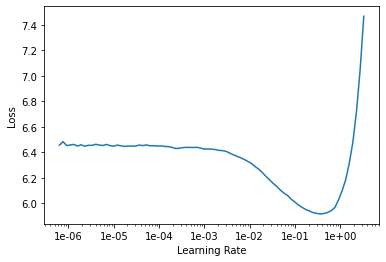

In [ ]:
lm.lr_find()
lm.recorder.plot()

In [ ]:
init_lr = 2e-02

In [ ]:
lm.fit_one_cycle(1, init_lr, moms=(0.8, 0.7))
lm.save('1_airline_sent140_lm')

epoch,train_loss,valid_loss,accuracy,time
0,4.185140,3.984999,0.254218,00:20


In [ ]:
lm.unfreeze()
lm.fit_one_cycle(8, init_lr * 0.1, moms=(0.8, 0.7))
lm.save('2_airline_sent140_lm')
lm.save_encoder('2_airline_sent140_lm')

epoch,train_loss,valid_loss,accuracy,time
0,3.714535,3.822793,0.275204,00:24
1,3.589730,3.720552,0.288673,00:24
2,3.323488,3.646763,0.303708,00:24
3,2.896444,3.622296,0.318776,00:24
4,2.429143,3.687033,0.332942,00:24
5,1.982242,3.803715,0.339167,00:24
6,1.660840,3.900834,0.341327,00:24
7,1.479543,3.955531,0.340340,00:24


Higher validation loss AND higher validation accuracy. And that's with a higher cardinality of tokens than before (which seems more impressive). Let's look at how well it does at creating complaint tweets.

In [ ]:
text = "My flight was cancelled due"
n_words = 40
n_sentences = 5
print("\n".join(lm.predict(text, n_words, temperature=0.8) for _ in range(n_sentences)))

My flight was cancelled due to maintenance . i 'm coming back to work thanks for the help xxbos @usairways why are there no agents at ORD ? i 'm taking a high note this afternoon with no updates ! xxbos Work for
My flight was cancelled due to maintenance . We are now rebooked on to CARING . You wo n't let us wait until next TUES . xxbos @southwestair Customer Service is very disappointing . xxbos @usairways your app was
My flight was cancelled due to mechanical issues . What does the status do to see the point of i being on hold for the other night ? xxbos Watching # Career In Pain , then . Now
My flight was cancelled due to maintenance . i 'm on the way home , now home alone for more than 2 hours xxbos Also , a Twitter 800 number is n't enough . Your site is down all it says ,
My flight was cancelled due to maintenance . i 'm to change a new flight and have to go back tomorrow . Do n't want to be here tonight . xxbos @southwestair So what do we do now ? The Cancelled


Still looks like good complaints to me. "Don't want to be here tonight." Solid

# Airline+Sentiment140 encoder with Airline-only Classifier

I imagine that the negative airline sentiments are specifically focused on frustration and anger, whereas the sentiment-140 dataset probably includes a wider swath of negative emotions - depression, disappointment, woe, etc. **This means that the 'negative' label in the sentiment-140 dataset probably represents something different than the 'negative' label in the airline dataset.**

Therefore, I will only use the airline data to train the derivative classifier, *not* sentiment140 + airline data.

In [ ]:
cls_data = (
    TextList
    .from_csv(data_path, 'filtered_train.csv', cols='text') # only train on the original airline data
    .split_by_rand_pct(0.1, seed=seed)
    .label_from_df(cols=0)
    .databunch(bs=bs)
)

There are many more vocabulary words in the airline+sentiment140 data than in the airline data alone

In [ ]:
# in order to continue training the old encoder behind the new classifier, we need the old encoder's vocabulary
cls_data.vocab.stoi = lm_data.vocab.stoi
cls_data.vocab.itos = lm_data.vocab.itos
cls = text_classifier_learner(cls_data, AWD_LSTM, drop_mult=0.5)
cls.load_encoder('2_airline_sent140_lm')

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


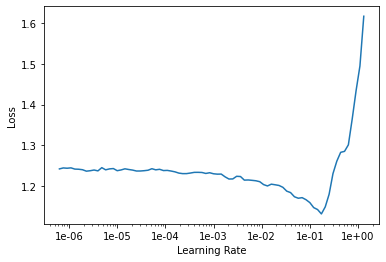

In [ ]:
cls.lr_find()
cls.recorder.plot()

In [ ]:
init_cls_lr = 1e-02
cls.fit_one_cycle(1, init_cls_lr, moms=(0.8, 0.7))
cls.save('1_sent140_cls')

epoch,train_loss,valid_loss,accuracy,time
0,0.815993,0.749078,0.691724,00:07


In [ ]:
cls.freeze_to(-2)
cls.fit_one_cycle(1, slice(init_cls_lr/(2.6**4), init_cls_lr), moms=(0.8,0.7))
cls.save('2_sent140_cls')

epoch,train_loss,valid_loss,accuracy,time
0,0.747582,0.706615,0.707669,00:09


In [ ]:
cls.freeze_to(-3)
new_cls_lr = init_cls_lr * 0.1
cls.fit_one_cycle(1, slice(new_cls_lr / (2.6**4), new_cls_lr), moms=(0.8, 0.7))
cls.save('3_sent140_cls')

epoch,train_loss,valid_loss,accuracy,time
0,0.684030,0.663778,0.729689,00:14


In [ ]:
cls.unfreeze()
cls.fit_one_cycle(6, slice(new_cls_lr / (2.6**4), new_cls_lr), moms=(0.8,0.7))
cls.save('4_sent140_cls')
cls.export('sent140_cls')

epoch,train_loss,valid_loss,accuracy,time
0,0.638421,0.648955,0.736522,00:17
1,0.610721,0.611217,0.747153,00:18
2,0.579503,0.592972,0.759301,00:17
3,0.482814,0.600679,0.763857,00:18
4,0.499397,0.588046,0.770691,00:17
5,0.441261,0.592773,0.766135,00:18


Doesn't look good. I don't think I'm going to be able to break 80% accuracy with this approach.

I guess sentiment140 was sufficiently different from the airline tweet distribution that it hurt more than it helped.

In [ ]:
cls = load_learner(data_path, 'sent140_cls')

In [ ]:
cls.predict("Your customer service is awful, you should be ashamed of yourselves. Never flying again")

(Category tensor(0), tensor(0), tensor([0.6554, 0.2183, 0.1263]))

In [ ]:
cls.predict("Thank you very much for helping me. I'm definitely flying with you again!")

(Category tensor(2), tensor(2), tensor([0.2247, 0.2837, 0.4916]))

In [ ]:
cls.predict("Stuck in line for an hour. I can't believe the customer service")

(Category tensor(0), tensor(0), tensor([0.9216, 0.0286, 0.0497]))

Definitely not as confident as the airline-only learner.

# See [this notebook](https://colab.research.google.com/drive/1P7-Om6yWwzliZUIepo7ftuRrYAkEGeDr) to see how well this model performed on the test set.